## Correct batch effect

Scgen batch correction.

- **INPUT:**
    -  ```counts_norm.mtx``` 
    -  ```anno_cells_norm.txt``` 
    -  ```anno_samples_norm.txt``` 
    -  ```anno_genes_norm.txt``` 
    -  ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
    
- **OUTPUT:**

    -  ```counts_corr.csv.gz``` 
    -  ```anno_cells_corr.txt``` 
    -  ```anno_samples_corr.txt``` 
    -  ```anno_genes_corr.txt``` 
    -  ```adata_afterCorrection.h5ad```

### load data

In [1]:
import scgen
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import numba as nb
import matplotlib.cm as cm
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
Global seed set to 0
/home/mami/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/mami/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `

In [2]:
#path_to_additional_files = "../../../data/data_preprocessing/Smillie/additional_input_files/"
#path_in = "../../../results/data_preprocessing/Smillie/normalized/"
#path_out = "../../../results/data_preprocessing/Smillie/batch_corrected/"

In [2]:
path_to_additional_files = "../../../data/Simillie/raw_data/cell_relabelling.csv"
path_in = "../../../results/data_preprocessing/Similie/normalized/"
path_out = "../../../results/data_preprocessing/bath_/"

In [3]:
# read in count table and create an adata object
adata_beforeCorrection = sc.read_mtx(path_in + "counts_norm.mtx",'float64').T

In [4]:
# read in cell annotation file
anno_cells = pd.read_csv(path_in + "anno_cells_norm.txt", sep = "\t") 

In [5]:
# read in sample annotation file
anno_samples = pd.read_csv(path_in + "anno_samples_norm.txt", sep = "\t") 

In [6]:
# read in gene annotation file
anno_genes = pd.read_csv(path_in + "anno_genes_norm.txt", sep = "\t") 

In [7]:
# load cell subtype and color keys
cell_relabel=pd.read_csv(path_to_additional_files + "cell_relabelling.csv"
                        ,sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/Simillie/raw_data/cell_relabelling.csvcell_relabelling.csv'

### process data

In [48]:
anno_genes

,gene_symbol,inDB,isLigand,isReceptor,sum_pseudobulkCellType_expr,sum_pseudobulkCellType_expr_threshold,sum_pseudobulkCellType_expr_filter,highly_variable,means,dispersions,dispersions_norm
gene_symbol,,,,,,,,,,,
A1BG-AS1,A1BG-AS1,False,False,False,7.384799,3,True,False,0.012750,0.446382,-0.893527
A1CF,A1CF,False,False,False,24.512929,3,True,False,0.061843,0.990651,0.434564
A2M,A2M,True,True,False,440.927120,3,True,True,0.422390,1.885322,1.267033
A4GALT,A4GALT,False,False,False,26.757556,3,True,False,0.021933,0.521128,-0.711136
AAAS,AAAS,False,False,False,36.348589,3,True,False,0.076351,0.743509,-0.168495
...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,ZXDC,False,False,False,10.652721,3,True,False,0.023730,0.849547,0.090250
ZYG11B,ZYG11B,False,False,False,19.059029,3,True,False,0.038725,0.683755,-0.314304
ZYX,ZYX,True,True,False,100.933280,3,True,False,0.106254,0.664227,-0.361955


In [9]:
adata_beforeCorrection.var_names=anno_genes['gene_symbol']
print("adata_beforeCorrection.var_names[1:10]")
print(adata_beforeCorrection.var_names[1:10])
adata_beforeCorrection.var = anno_genes
adata_beforeCorrection.var.index = adata_beforeCorrection.var.index.astype(str)

adata_beforeCorrection.var_names[1:10]
Index(['A1CF', 'A2M', 'A4GALT', 'AAAS', 'AACS', 'AAED1', 'AAGAB', 'AAK1',
       'AAMDC'],
      dtype='object', name='gene_symbol')


In [10]:
adata_beforeCorrection.obs_names=anno_cells['cell_ID']
print("adata_beforeCorrection.obs_names[1:10]")
print(adata_beforeCorrection.obs_names[1:10])
adata_beforeCorrection.obs = anno_cells
adata_beforeCorrection.obs.index = adata_beforeCorrection.obs.index.astype(str)

adata_beforeCorrection.obs_names[1:10]
Index(['N10.EpiA.AACCCAGACGTAAC', 'N10.EpiA.AATCTCACCGCATA',
       'N10.EpiA.ACAATAACCGCTAA', 'N10.EpiA.ACAATTGATGCAGT',
       'N10.EpiA.ACAGTGTGTTGGTG', 'N10.EpiA.ACCGTGCTACTCAG',
       'N10.EpiA.ACGAGGGAACCTAG', 'N10.EpiA.ACGCAATGGTAGCT',
       'N10.EpiA.ACTACGGAAAGAAC'],
      dtype='object', name='cell_ID')


In [11]:
adata_beforeCorrection.obs_region=anno_cells['region']
adata_beforeCorrection.obs_health_status=anno_cells['health_status']


cells_to_keep_inflamed_non_inflamed = ["Inflamed", "Non-inflamed"]
adata_filtered1 = adata_beforeCorrection[adata_beforeCorrection.obs["region"].isin(cells_to_keep_inflamed_non_inflamed)].copy()

cells_to_keep_inflamed_healthy = ["Inflamed", "Healthy"]
adata_filtered2 = adata_beforeCorrection[adata_beforeCorrection.obs["region"].isin(cells_to_keep_inflamed_healthy)].copy()


In [12]:
inflamed_color = "#7C001F"  # Red color for Inflamed
non_inflamed_color = "#7AC5CD"  # Green color for Non-inflamed
healthy_color = "#7AC5CD"  # Blue color for Healthy

color_map_inflamed_non_inflamed = {
    "Inflamed": inflamed_color,
    "Non-inflamed": non_inflamed_color
}

color_map_inflamed_healthy = {
    "Inflamed": inflamed_color,
    "Healthy": healthy_color
}

In [13]:
adata_beforeCorrection

AnnData object with n_obs × n_vars = 93593 × 13861
    obs: 'cell_ID', 'cell_type_original', 'tissue_type', 'cell_type', 'region', 'sample_ID', 'health_status', 'total_counts_raw', 'nr_genes', 'counts_upper_threshold', 'counts_lower_threshold', 'genes_lower_threshold', 'counts_upper_filter', 'counts_lower_filter', 'genes_lower_filter', 'cell_filter', 'threshold_celltype_size', 'celltype_size_cf', 'celltype_size_filter', 'cell_type_ID', 'total_counts_raw_cf_ctf_gf', 'total_counts_raw_cf_ctf_gf_sf', 'sizeFactor'
    var: 'gene_symbol', 'inDB', 'isLigand', 'isReceptor', 'sum_pseudobulkCellType_expr', 'sum_pseudobulkCellType_expr_threshold', 'sum_pseudobulkCellType_expr_filter'

### prepare for the visualization

In [14]:
# define colors
colors_cell_type=dict(zip(cell_relabel["cell_type"],cell_relabel["cell_type_color"]))
print(colors_cell_type)

{'Stem and multipotent cells': '#c68642', 'Enterocytes': '#CB4335', 'M cells': '#f1c27d', 'Goblet': '#8d5523', 'Tuft': '#ffdbac', 'Fibroblasts': '#d896ff', 'Vascular': '#be29ec', 'Glia': '#660066', 'Macrophages': '#b3cde0', 'Myeloid': '#6497b1', 'Mast': '#005b96', 'Nks': '#43e8d8', 'ILCs': '#b3ecec', 'CD4': '#011f4b', 'Tregs': '#428bca', 'CD8': '#71c7ec', 'Cycling T': '#107dac', 'Plasma': '#189ad3', 'B-cells': '#1ebbd7'}


In [15]:
adata_beforeCorrection.obs["cell_type_original"].value_counts()

Plasma                      26455
Cycling TA                   5870
TA 2                         5307
Follicular                   4847
Immature Enterocytes 2       3437
TA 1                         3201
CD8+ LP                      3115
CD4+ Memory                  3098
Macrophages                  2935
CD4+ Activated Fos-hi        2771
Immature Goblet              2698
CD4+ Activated Fos-lo        2447
Immature Enterocytes 1       2085
WNT2B+ Fos-lo 1              2078
Tregs                        1926
Enterocytes                  1860
WNT2B+ Fos-hi                1802
Secretory TA                 1673
Enterocyte Progenitors       1520
Cycling B                    1063
WNT5B+ 2                     1056
WNT5B+ 1                     1004
CD69+ Mast                    945
Best4+ Enterocytes            939
CD8+ IELs                     923
Post-capillary Venules        877
Stem                          875
DC2                           820
Endothelial                   779
Myofibroblasts

In [16]:
# define color schemes
colors_cell_subtype=dict(zip(cell_relabel["cell_type_original"],cell_relabel["cell_type_original_color"]))
print(colors_cell_subtype)

colors_cell_type=dict(zip(cell_relabel["cell_type"],cell_relabel["cell_type_color"]))
print(colors_cell_type)

{'Stem': '#CB4335', 'TA 1': '#CB4335', 'TA 2': '#CB4335', 'Cycling TA': '#CB4335', 'Immature Enterocytes 1': '#CB4335', 'Immature Enterocytes 2': '#CB4335', 'Enterocyte Progenitors': '#CB4335', 'Enterocytes': '#CB4335', 'M cells': '#CB4335', 'Best4+ Enterocytes': '#CB4335', 'Secretory TA': '#CB4335', 'Immature Goblet': '#CB4335', 'Goblet': '#CB4335', 'Tuft': '#CB4335', 'Enteroendocrine': '#CB4335', 'WNT2B+ Fos-hi': '#8E44AD', 'WNT2B+ Fos-lo 1': '#8E44AD', 'WNT2B+ Fos-lo 2': '#8E44AD', 'RSPO3+': '#8E44AD', 'WNT5B+ 1': '#8E44AD', 'WNT5B+ 2': '#8E44AD', 'Inflammatory Fibroblasts': '#8E44AD', 'Myofibroblasts': '#8E44AD', 'Endothelial': '#8E44AD', 'Microvascular': '#8E44AD', 'Post-capillary Venules': '#8E44AD', 'Pericytes': '#8E44AD', 'Glia': '#8E44AD', 'Macrophages': '#F09040', 'DC1': '#F09040', 'DC2': '#F09040', 'Inflammatory Monocytes': '#F09040', 'CD69+ Mast': '#F09040', 'CD69- Mast': '#F09040', 'Cycling Monocytes': '#F09040', 'NKs': '#4F92EE', 'ILCs': '#4F92EE', 'CD4+ Activated Fos-hi'

In [17]:
adata_beforeCorrection.uns["region_colors"] = ["#7AC5CD" # bordeau for colitis
                                                     , "#7C001F" # CadetBlue3 for healthy
                                                     ]
adata_beforeCorrection.uns["health_status_colors"] = ["#7C001F" # bordeau for colitis
                                                     ,"#7AC5CD"  # CadetBlue3 for healthy
                                                     ]                            

adata_beforeCorrection.uns["sample_ID_colors"] = ["#A6ACAF" # grey for FALSE
                                                  , "#C0392B" # red for TRUE
                                                 ]

In [18]:
adata_beforeCorrection.obs['cell_type_original'] = adata_beforeCorrection.obs['cell_type_original'].astype('category')

new_categories = [
    "Stem","TA 1","TA 2","Cycling TA","Immature Enterocytes 1","Immature Enterocytes 2","Enterocyte Progenitors","Enterocytes","M cells","Best4+ Enterocytes","Secretory TA","Immature Goblet","Goblet","Enteroendocrine","WNT2B+ Fos-hi","WNT2B+ Fos-lo 1","WNT2B+ Fos-lo 2","RSPO3+","WNT5B+ 1","WNT5B+ 2","Inflammatory Fibroblasts","Myofibroblasts","Endothelial","Microvascular","Post-capillary Venules","Pericytes","Macrophages","DC1","DC2","Inflammatory Monocytes","CD69+ Mast","CD69- Mast","Cycling Monocytes","NKs","CD4+ Activated Fos-hi","CD4+ Activated Fos-lo","CD4+ Memory","Tregs","CD4+ PD1+","CD8+ IELs","CD8+ LP","CD8+ IL17+","MT-hi","Cycling T","Plasma","Follicular","GC","Cycling B","Tuft"
]

adata_beforeCorrection.obs['cell_type_original'].cat.set_categories(new_categories, inplace=True)


/tmp/ipykernel_43321/3670753621.py:7: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata_beforeCorrection.obs['cell_type_original'].cat.set_categories(new_categories, inplace=True)


In [19]:
cell_types = adata_beforeCorrection.obs['cell_type_original'].unique()

# Generate a list of colors from viridis color map with the same length as cell_types
colors = cm.plasma(np.linspace(0, 1, len(cell_types)))

# Map each cell type to a color in the dictionary
cell_type_original_vir = dict(zip(cell_types, colors))

In [20]:
from matplotlib.cm import get_cmap
# Get the categories from the 'cell_type_original' column
categories = adata_beforeCorrection.obs['cell_type_original'].cat.categories

# Check for missing categories in the palette and add them
missing_categories = [cat for cat in categories if cat not in cell_type_original_vir]

if missing_categories:
    # Get a colormap (you can change this to any matplotlib colormap you like)
    cmap = get_cmap('viridis')

    # Determine the color step based on the number of missing categories
    color_step = 1.0 / (len(missing_categories) + 1)

    # Assign colors to the missing categories
    for i, cat in enumerate(missing_categories):
        color = cmap(i * color_step)
        cell_type_original_vir[cat] = color

    print(f"Added colors for {len(missing_categories)} missing categories.")
else:
    print("All categories are present in the palette.")


Added colors for 4 missing categories.


/tmp/ipykernel_43321/4160897058.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


### visualize before batch correction

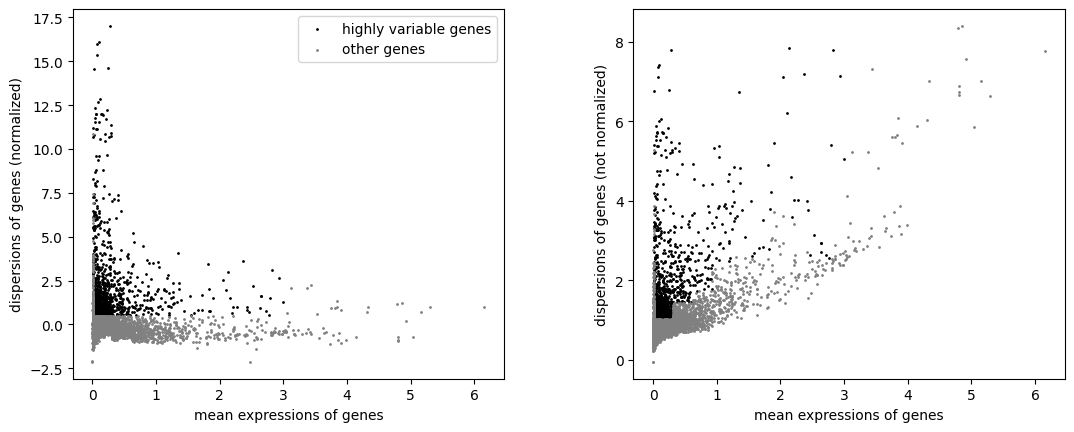

In [21]:
# logtransform before HVG calculation
sc.pp.log1p(adata_beforeCorrection)

sc.pp.highly_variable_genes(adata_beforeCorrection)
sc.pl.highly_variable_genes(adata_beforeCorrection)

In [22]:
# print how many HVGs we have:
print("Nr of HVGs:")
print(sum(adata_beforeCorrection.var.highly_variable))

Nr of HVGs:
1473


In [23]:
sc.tl.pca(adata_beforeCorrection, svd_solver='arpack')

/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


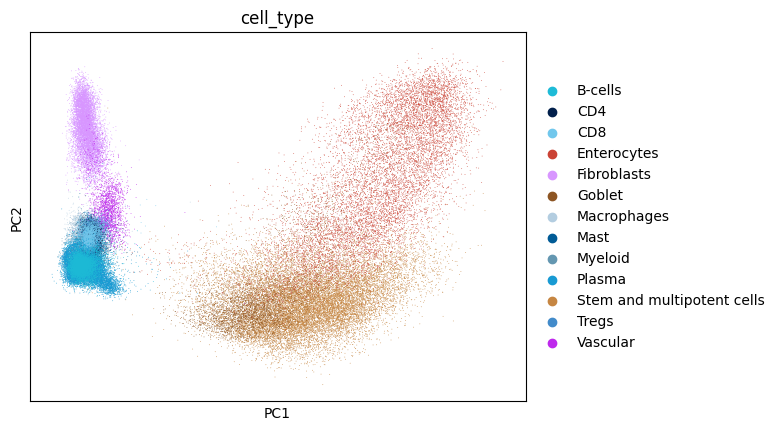

In [24]:
sc.pl.pca(adata_beforeCorrection
          , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_beforeCorrection_cell_type.pdf"
         )

In [25]:
sc.pp.neighbors(adata_beforeCorrection)

In [26]:
sc.tl.umap(adata_beforeCorrection)

In [27]:
# Create subsets of the data for the desired regions
adata_filtered1 = adata_beforeCorrection[adata_beforeCorrection.obs["region"].isin(cells_to_keep_inflamed_non_inflamed)].copy()
adata_filtered2 = adata_beforeCorrection[adata_beforeCorrection.obs["region"].isin(cells_to_keep_inflamed_healthy)].copy()

# Calculate neighbors and UMAP embeddings for the filtered datasets
sc.pp.neighbors(adata_filtered1)
sc.tl.umap(adata_filtered1)

sc.pp.neighbors(adata_filtered2)
sc.tl.umap(adata_filtered2)

/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


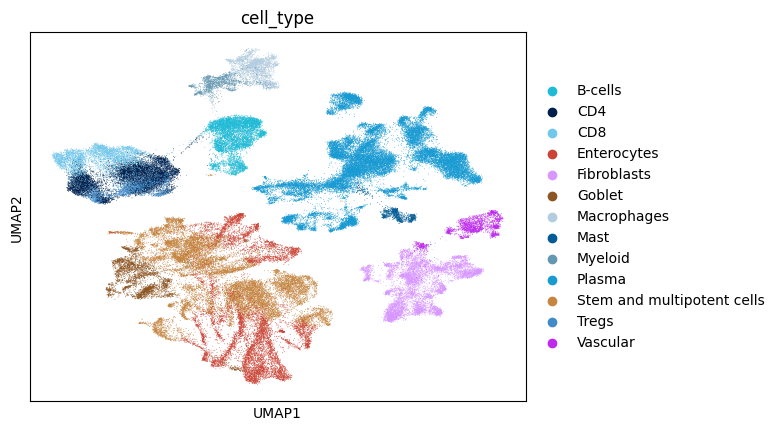

In [28]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_type"]
          , palette=colors_cell_type
          ,save="_beforeCorrection_cell_type.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


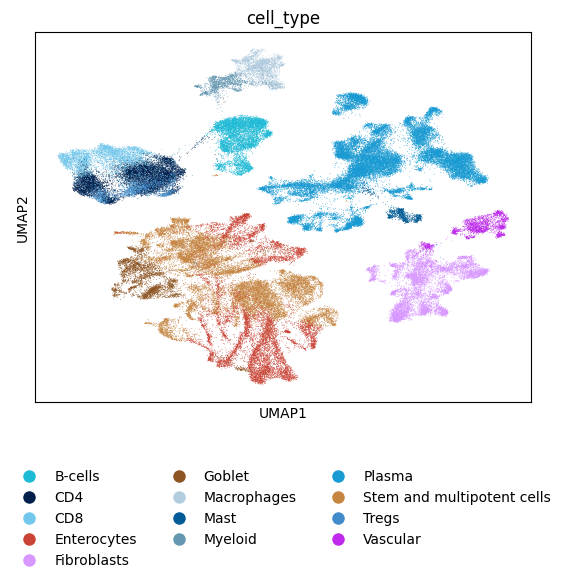

In [29]:


# Create the UMAP plot without displaying the legend
ax = sc.pl.umap(adata_beforeCorrection,
                color=["cell_type"],
                palette=colors_cell_type,
                legend_loc=None, # Suppress the automatic legend
                show=False) # Don't show the plot immediately

# Get the categories and their corresponding colors
categories = adata_beforeCorrection.obs["cell_type"].cat.categories
colors = [colors_cell_type[cat] for cat in categories]

# Create a custom legend at the bottom without a frame
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors],
           labels=list(categories),
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15), # Adjust this to change the position
           ncol=3, # Adjust this to change the number of columns
           frameon=False) # Remove the frame

# Save the figure
plt.savefig("_beforeCorrection_cell_type.pdf")

# Show the plot
plt.show()


/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


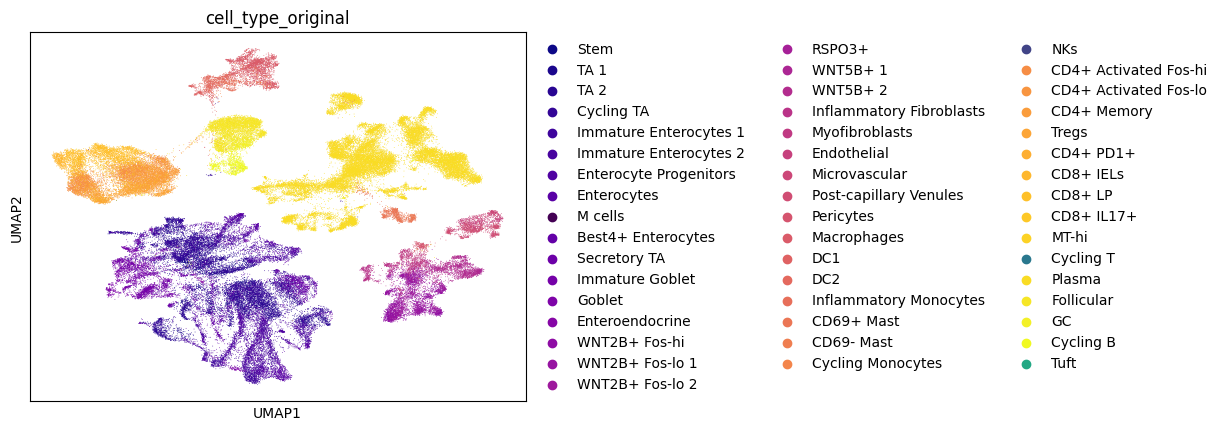

In [30]:
sc.pl.umap(adata_beforeCorrection
          ,color="cell_type_original"
          ,palette=cell_type_original_vir
          ,save="_beforeCorrection_cell_subtype.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


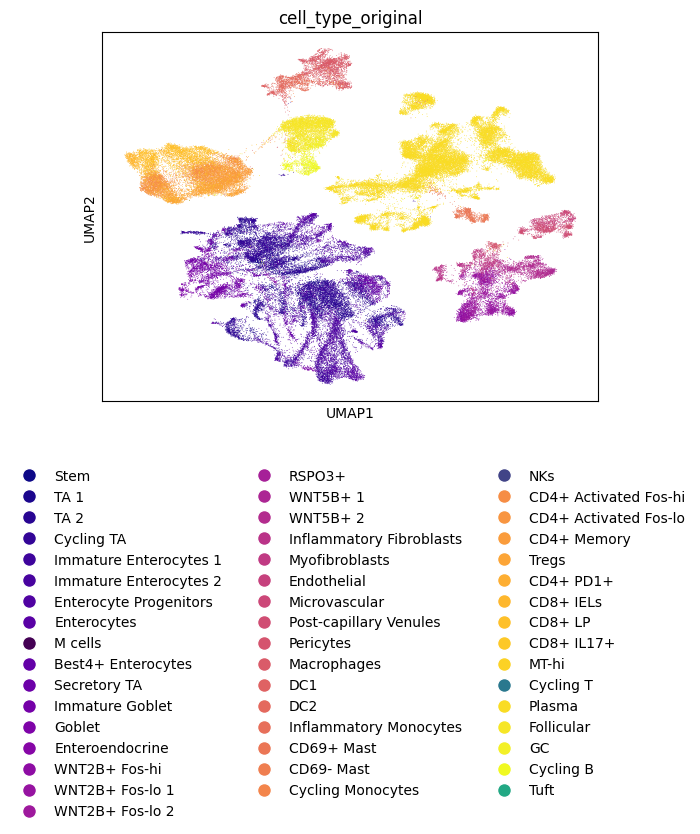

In [31]:
import matplotlib.pyplot as plt

# Create the UMAP plot without displaying the legend
ax = sc.pl.umap(adata_beforeCorrection,
                color="cell_type_original",
                palette=cell_type_original_vir,
                legend_loc=None, # Suppress the automatic legend
                show=False) # Don't show the plot immediately

# Get the categories and their corresponding colors from the palette
categories = adata_beforeCorrection.obs["cell_type_original"].cat.categories
colors = [cell_type_original_vir[cat] for cat in categories]

# Create a custom legend at the bottom without a frame
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors],
           labels=list(categories),
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15), # Adjust this to change the position
           ncol=3, # Adjust this to change the number of columns
           frameon=False) # Remove the frame

# Save the figure
plt.savefig("_beforeCorrection_cell_subtype.pdf")

# Show the plot
plt.show()


/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


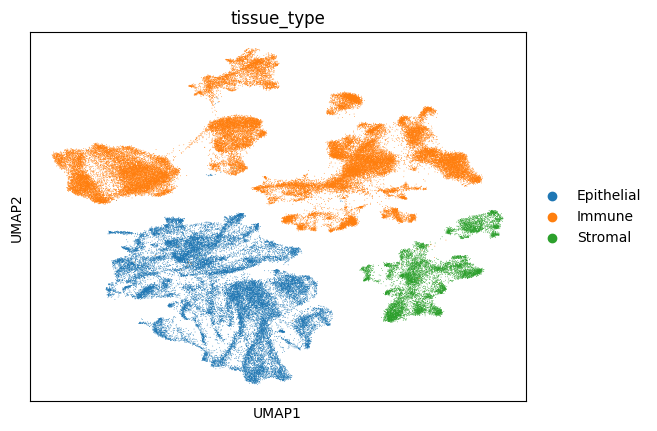

In [32]:
sc.pl.umap(adata_beforeCorrection
           , color=["tissue_type"]
          # , palette="viridis"
          ,save="_beforeCorrection_tissue_type.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


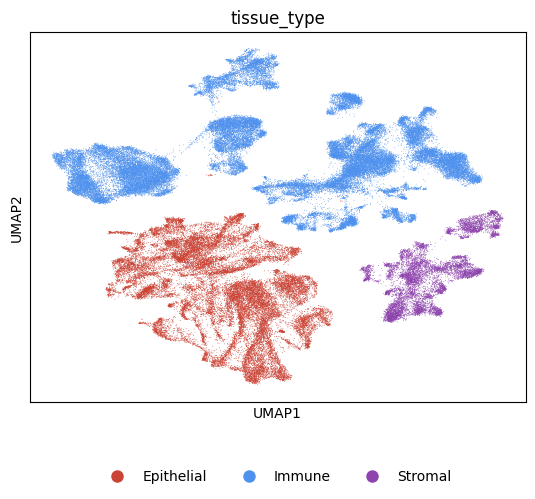

In [33]:
# Define the palette for tissue_type
palette = {
    'Epithelial': '#CB4335',
    'Immune': '#4F92EE',
    'Stromal': '#8E44AD'
}

# Create the UMAP plot without displaying the legend
ax = sc.pl.umap(adata_beforeCorrection,
                color="tissue_type",
                palette=palette,
                legend_loc=None, # Suppress the automatic legend
                show=False) # Don't show the plot immediately

# Get the categories and their corresponding colors
categories = adata_beforeCorrection.obs["tissue_type"].cat.categories
colors = [palette[cat] for cat in categories]

# Create a custom legend at the bottom without a frame
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors],
           labels=list(categories),
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15), 
           ncol=3, 
           frameon=False) 

# Show the plot
plt.show()


/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


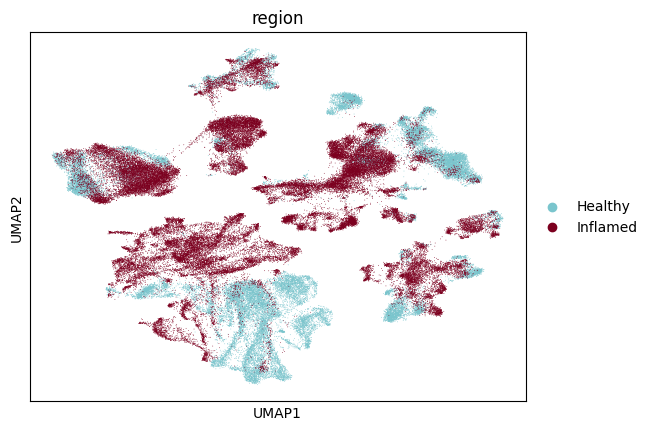

In [34]:
sc.pl.umap(adata_beforeCorrection
           , color=["region"]
          ,save="_beforeCorrection_region.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


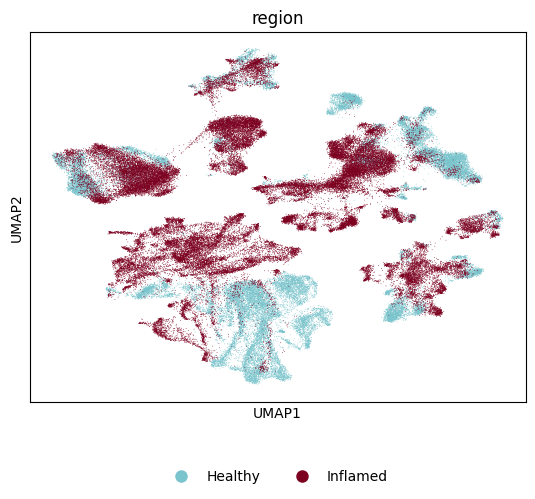

In [35]:
# Create the UMAP plot without displaying the legend
ax = sc.pl.umap(adata_beforeCorrection,
                color="region",
                legend_loc=None, # Suppress the automatic legend
                show=False) # Don't show the plot immediately

# Get the categories and use the predefined colors
categories = adata_beforeCorrection.obs["region"].cat.categories
colors = adata_beforeCorrection.uns["region_colors"]

# Create a custom legend at the bottom without a frame
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors],
           labels=list(categories),
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15), # Adjust this to change the position
           ncol=3, # Adjust this to change the number of columns
           frameon=False) # Remove the frame

plt.show()


/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


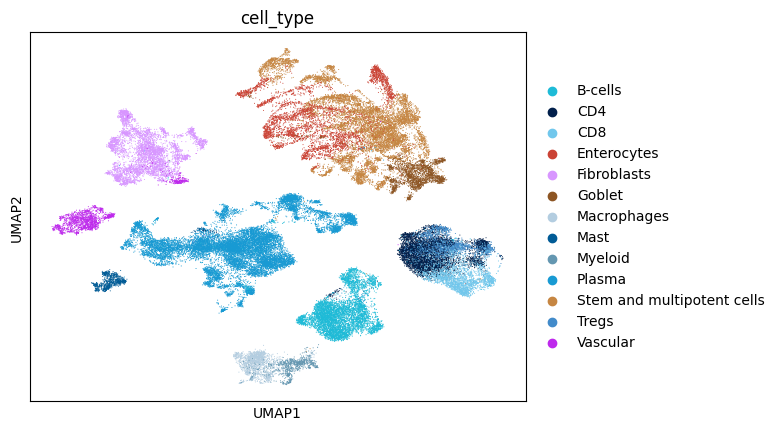

In [36]:
sc.pl.umap(adata_filtered1, color='cell_type', palette=colors_cell_type, save="_beforeCorrection_region_inflamed_non_inflamed_celltype.pdf")

/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


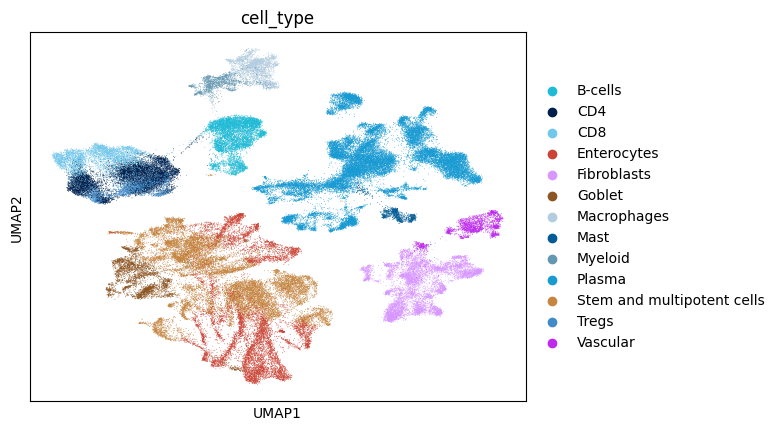

In [37]:
sc.pl.umap(adata_filtered2, color='cell_type', palette=colors_cell_type,save="_beforeCorrection_region_inflamed_healthy_celltype.pdf")

/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


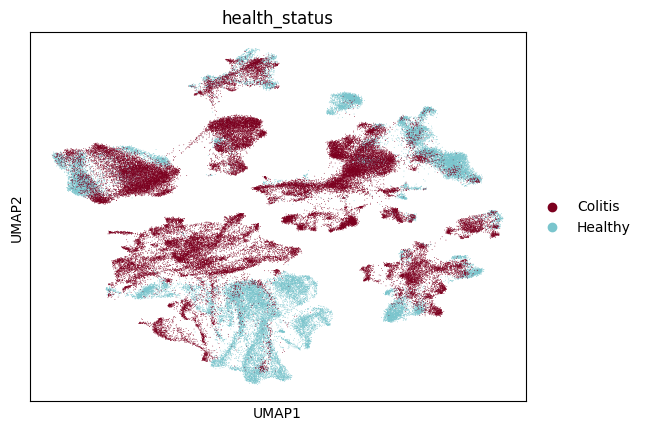

In [38]:
sc.pl.umap(adata_beforeCorrection
           , color=["health_status"]
          ,save="_beforeCorrection_health_status.pdf"
          )

In [39]:
print(adata_beforeCorrection.obs['cell_type_original'].unique())

['Stem', 'TA 1', 'TA 2', 'Cycling TA', 'Immature Enterocytes 1', ..., 'MT-hi', 'Plasma', 'Follicular', 'GC', 'Cycling B']
Length: 45
Categories (49, object): ['Stem', 'TA 1', 'TA 2', 'Cycling TA', ..., 'Follicular', 'GC', 'Cycling B', 'Tuft']


/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


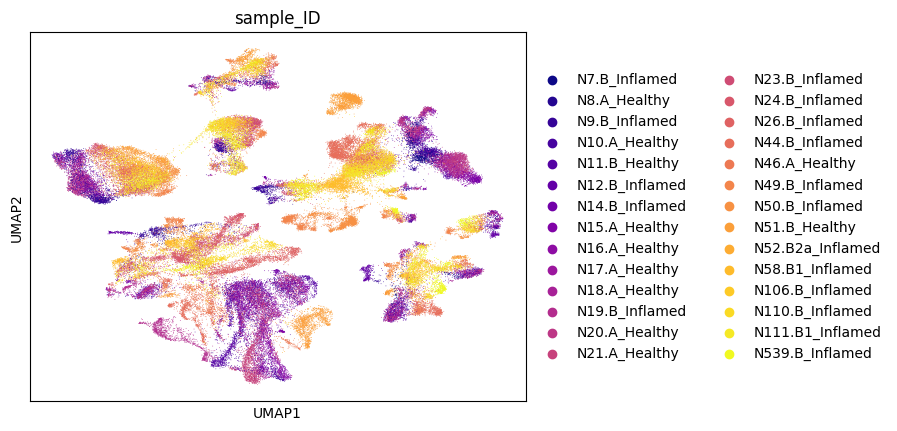

In [40]:
sc.pl.umap(adata_beforeCorrection
           , color=["sample_ID"]
           , palette="plasma"
           ,save="_beforeCorrection_sample_ID.pdf"
          )

/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


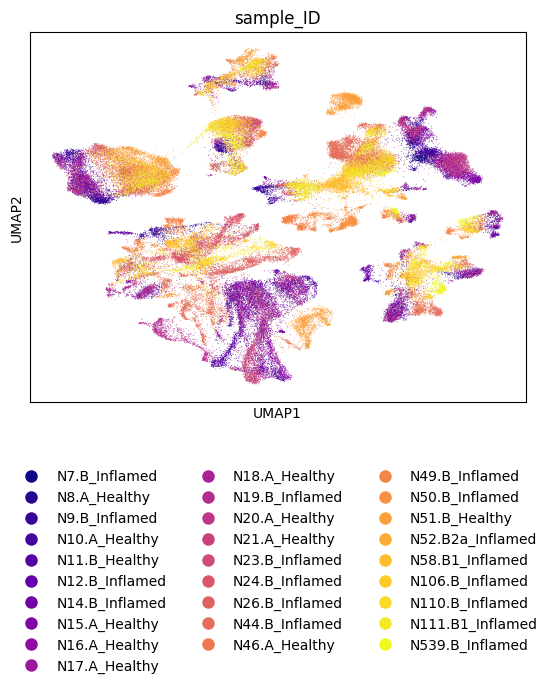

In [41]:
# Create the UMAP plot without displaying the legend
ax = sc.pl.umap(adata_beforeCorrection,
                color=["sample_ID"],
                palette="plasma",
                legend_loc=None, # Suppress the automatic legend
                show=False) # Don't show the plot immediately

# Get the categories and their corresponding colors
categories = adata_beforeCorrection.obs["sample_ID"].cat.categories
colors = [plt.cm.plasma(i) for i in np.linspace(0, 1, len(categories))]

# Create a custom legend at the bottom without a frame
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors],
           labels=list(categories),
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15), # Adjust this to change the position
           ncol=3, # Adjust this to change the number of columns
           frameon=False) # Remove the frame

# Save the figure
plt.savefig("_beforeCorrection_sample_ID.pdf")

# Show the plot
plt.show()


/work/project/ladcol_011/conda_path/miniconda3/envs/new5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


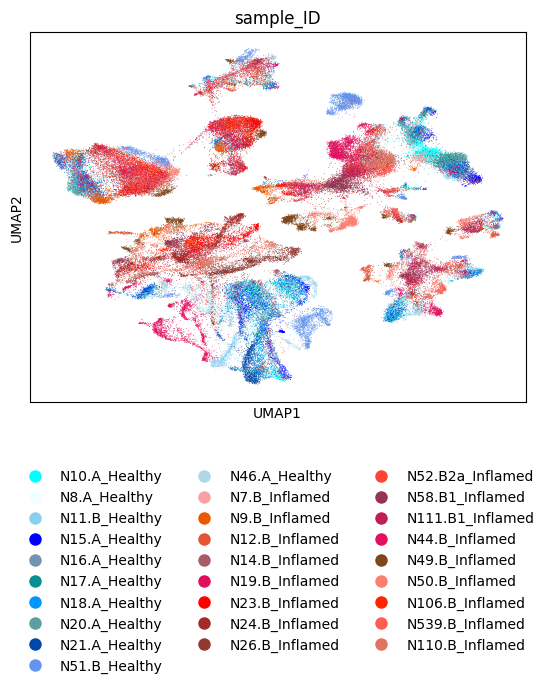

In [42]:
import scanpy as sc
import matplotlib.pyplot as plt

# Define the HEX codes for blue (you can choose 11 shades from this list)
blue_colors = [
    "#00FFFF", "#F0FFFF", "#89CFF0", "#0000FF", "#7393B3", "#088F8F",
    "#0096FF", "#5F9EA0", "#0047AB", "#6495ED", "#ADD8E6"
]

# Define the HEX codes for 17 shades of red for "Inflamed" samples
red_colors = [
    "#FAA0A0", "#EC5800", "#E35335", "#A95C68", "#E30B5C", "#FF0000",
    "#A52A2A", "#913831", "#FF4433", "#953553", "#C21E56", "#E0115F",
    "#80461B", "#FA8072", "#FF2400", "#FA5F55", "#E3735E"
]

# Create a dictionary to map sample IDs to colors
colors_sample_ID = {}
unique_sample_IDs = adata_beforeCorrection.obs['sample_ID'].unique()
blue_index = 0
red_index = 0
for sample_id in unique_sample_IDs:
    if 'Inflamed' in sample_id:
        colors_sample_ID[sample_id] = red_colors[red_index] # Assigning unique red shades to Inflamed samples
        red_index += 1
    elif 'Healthy' in sample_id:
        colors_sample_ID[sample_id] = blue_colors[blue_index] # Assigning unique blue shades to Healthy samples
        blue_index += 1

# Create the UMAP plot without displaying the legend
ax = sc.pl.umap(adata_beforeCorrection,
                color=["sample_ID"],
                palette=colors_sample_ID,
                legend_loc=None, # Suppress the automatic legend
                show=False) # Don't show the plot immediately

# Create a custom legend at the bottom without a frame
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_sample_ID.values()],
           labels=list(colors_sample_ID.keys()),
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15), # Adjust this to change the position
           ncol=3, # Adjust this to change the number of columns
           frameon=False) # Remove the frame

# Save the figure
plt.savefig("_beforeCorrection_sample_ID.pdf")

# Show the plot
plt.show()


In [43]:
adata_beforeCorrection.var = anno_genes
adata_beforeCorrection.var.index = adata_beforeCorrection.var.index.astype(str)
adata_beforeCorrection.var_names=anno_genes['gene_symbol']

In [44]:
# export counts as csv.gz
print("save counts_corr.csv.gz")

counts_corr=pd.DataFrame(adata_beforeCorrection.X
                        ,columns=adata_beforeCorrection.var_names 
                        ,index=adata_beforeCorrection.obs_names
                        ).transpose()
counts_corr.to_csv(path_out + "counts_corr.csv.gz"
                   ,index=True
                   ,compression="gzip"
                   )

save counts_corr.csv.gz


ValueError: Shape of passed values is (93593, 1), indices imply (93593, 13861)

## Batch correction

In [ ]:
# preprocess for batch correction
scgen.SCGEN.setup_anndata(adata_beforeCorrection, batch_key="sample_ID", labels_key="cell_type")

In [ ]:
# create model
network = scgen.SCGEN(adata_beforeCorrection)

In [ ]:
# train model
network.train(max_epochs=100,
            batch_size=32,
            early_stopping=True,
            early_stopping_patience=40,
)


In [ ]:
# remove batch effect
adata_afterCorrection =  network.batch_removal()

In [ ]:
# restore annotations
adata_afterCorrection.var = anno_genes
adata_afterCorrection.var.index = adata_afterCorrection.var.index.astype(str)
adata_afterCorrection.var_names=anno_genes['gene_symbol']
print("adata_afterCorrection.var_names[1:10]")
print(adata_afterCorrection.var_names[1:10])

In [ ]:
adata_afterCorrection.obs = anno_cells
adata_afterCorrection.obs.index = adata_afterCorrection.obs.index.astype(str)
adata_afterCorrection.obs_names=anno_cells['cell_ID']
print("adata_afterCorrection.obs_names[1:10]")
print(adata_afterCorrection.obs_names[1:10])

In [ ]:
print("adata_afterCorrection")
print(adata_afterCorrection)

In [ ]:
sc.pp.highly_variable_genes(adata_afterCorrection)
sc.pl.highly_variable_genes(adata_afterCorrection)

In [ ]:
sc.tl.pca(adata_afterCorrection, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata_afterCorrection
          , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_afterCorrection_cell_type.pdf"
         )

In [ ]:
sc.pp.neighbors(adata_afterCorrection)

In [ ]:
sc.tl.umap(adata_afterCorrection)

In [ ]:
adata_afterCorrection.uns["health_status_colors"] = ["#7C001F" # bordeau for AML
                                                     , "#7ac5cd" # CadetBlue3 for healthy
                                                     ]

In [ ]:
palette = {
    'Epithelial': '#CB4335',
    'Immune': '#4F92EE',
    'Stromal': '#8E44AD'
}

ax = sc.pl.umap(adata_afterCorrection,
                color="tissue_type",
                palette=palette,
                legend_loc=None,
                show=False) 

categories = adata_afterCorrection.obs["tissue_type"].cat.categories
colors = [palette[cat] for cat in categories]

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors],
           labels=list(categories),
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15), 
           ncol=3, 
           frameon=False) 

plt.show()

In [ ]:
ax = sc.pl.umap(adata_afterCorrection,
                color=["cell_type"],
                palette=colors_cell_type,
                legend_loc=None,
                show=False) 

categories = adata_afterCorrection.obs["cell_type"].cat.categories
colors = [colors_cell_type[cat] for cat in categories]

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors],
           labels=list(categories),
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=3, 
           frameon=False)
plt.show()


In [ ]:
# Define the color codes for blue
blue_colors = [
    "#00FFFF", "#F0FFFF", "#89CFF0", "#0000FF", "#7393B3", "#088F8F",
    "#0096FF", "#5F9EA0", "#0047AB", "#6495ED", "#ADD8E6"
]

# Define the color codes for 17 shades of red for "Inflamed" samples
red_colors = [
    "#FAA0A0", "#EC5800", "#E35335", "#A95C68", "#E30B5C", "#FF0000",
    "#A52A2A", "#913831", "#FF4433", "#953553", "#C21E56", "#E0115F",
    "#80461B", "#FA8072", "#FF2400", "#FA5F55", "#E3735E"
]

colors_sample_ID = {}
unique_sample_IDs = adata_afterCorrection.obs['sample_ID'].unique()
blue_index = 0
red_index = 0
for sample_id in unique_sample_IDs:
    if 'Inflamed' in sample_id:
        colors_sample_ID[sample_id] = red_colors[red_index] 
        red_index += 1
    elif 'Healthy' in sample_id:
        colors_sample_ID[sample_id] = blue_colors[blue_index] 
        blue_index += 1

ax = sc.pl.umap(adata_afterCorrection,
                color=["sample_ID"],
                palette=colors_sample_ID,
                legend_loc=None, 
                show=False) 

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_sample_ID.values()],
           labels=list(colors_sample_ID.keys()),
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=3,
           frameon=False) 

plt.show()

In [ ]:
ax = sc.pl.umap(adata_afterCorrection,
                color="health_status",
                legend_loc=None,
                show=False) 

categories = adata_afterCorrection.obs["health_status"].cat.categories
colors = adata_afterCorrection.uns["health_status_colors"]
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors],
           labels=list(categories),
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=3,
           frameon=False)

plt.show()

## Export

In [ ]:
# export counts as csv.gz
print("save counts_corr.csv.gz")

counts_corr=pd.DataFrame(adata_beforeCorrection.X
                        ,columns=adata_beforeCorrection.var_names 
                        ,index=adata_beforeCorrection.obs_names
                        ).transpose()
counts_corr.to_csv(path_out + "counts_corr.csv.gz"
                   ,index=True
                   ,compression="gzip"
                   )

In [ ]:
# export anno_cells_corr
print("save anno_cells_corr.txt")
adata_afterCorrection.obs.to_csv(path_out + "anno_cells_corr.txt"
                    ,sep = "\t"
                    ,index = True)


In [ ]:
# export anno_samples_corr
print("save anno_samples_corr.txt")
anno_samples.to_csv(path_out + "anno_samples_corr.txt"
                    ,sep = "\t"
                    ,index = True)

In [ ]:
# export anno_genes_corr
print("save anno_genes_corr.txt")
adata_afterCorrection.var.to_csv(path_out + "anno_genes_corr.txt"
                    ,sep = "\t"
                    ,index = True)

In [ ]:
# export adata object
print("save adata_beforeCorrection.h5ad")
adata_beforeCorrection.write(path_out + "adata_beforeCorrection.h5ad")